In [1]:
import pandas as pd
import sqlite3
import re
import nltk
import spacy
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
nlp=spacy.load("en_core_web_sm")

nltk.download("punct")
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


[nltk_data] Error loading punct: Package 'punct' not found in index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gacha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gacha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Data collection from sql database

In [2]:

conn = sqlite3.connect("jumia_data.db")

products_df=pd.read_sql("SELECT * FROM products",conn)
reviews_df=pd.read_sql("SELECT * FROM reviews",conn)

merge_df=pd.merge(reviews_df,products_df,left_on="product_id",right_on='id')

merged_df = merge_df.drop(columns=['id_x',"id_y","product_id"])

print(merged_df.columns)


conn.close()

Index(['review_about', 'sentiment', 'star_rating', 'date', 'product_name',
       'price', 'ratings', 'discount', 'brand', 'number_of_reviews'],
      dtype='object')


In [3]:
merged_df.head(5)

,review_about,sentiment,star_rating,date,product_name,price,ratings,discount,brand,number_of_reviews
0,A70,Good buy ????,5,04-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0
1,Good,"Not bad for the price, good battery , storage ...",4,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0
2,performance,Hangs alot,1,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0
3,Phone,Good phone,5,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0
4,Bwst,I loved it!!am going to purchase more Thanks J...,5,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0


In [4]:
merged_df.dtypes

review_about          object
sentiment             object
star_rating           object
date                  object
product_name          object
price                float64
ratings               object
discount              object
brand                 object
number_of_reviews    float64
dtype: object

### DATA CLEANING

In [5]:
merged_df["star_rating"]=merged_df["star_rating"].astype("float")
merged_df["sentiment"]=merged_df["sentiment"].astype("string")
merged_df["ratings"]=pd.to_numeric(merged_df["ratings"],errors="coerce")
merged_df=merged_df.dropna(subset=["ratings","brand"])

In [6]:
def map_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

merged_df["sentiment_classification"]=merged_df["star_rating"].apply(map_sentiment)

In [7]:
def cleaning_text(text):
    if pd.isna(text):
        return ""
    text=text.lower()
    cleaned=re.sub(r"[^\w\s'-]|(?<!\w)'|'(?!\w)|(?<!\w)-|-(?!\w)","",text) # removing punctuations
    return cleaned

merged_df["simple_cleaning"]=merged_df["sentiment"].apply(cleaning_text)

In [8]:
def lematization(text):
    doc=nlp(text)
    tokens=[token.lemma_ for token in doc if not token.is_space]
    return tokens

merged_df["lematizated_tech"]= merged_df["simple_cleaning"].apply(lematization)


In [9]:
text=" ".join([item for sublist in merged_df.lematizated_tech for item in sublist])

In [10]:
wt=nltk.WhitespaceTokenizer()
tokenized=wt.tokenize(text)

In [11]:
word_freq=Counter(tokenized)
most_common_words=word_freq.most_common(10)
print(most_common_words)

[('be', 565), ('the', 483), ('it', 380), ('good', 269), ('phone', 259), ('I', 247), ('and', 236), ('a', 173), ('not', 144), ('work', 143)]


In [12]:
def word_freq_plot(most_common_words):
  data=pd.DataFrame(most_common_words,columns=["Word","Frequency"])
  fig=plt.subplots(figsize=(8,4))
  sns.barplot(data=data,x="Word",y="Frequency")
  plt.title("Most_frequent_words")
  plt.xticks(rotation=45)
  new_fig=plt.show()
#   plt.tight_layout()
  return new_fig
# word_freq_plot(most_common_words)

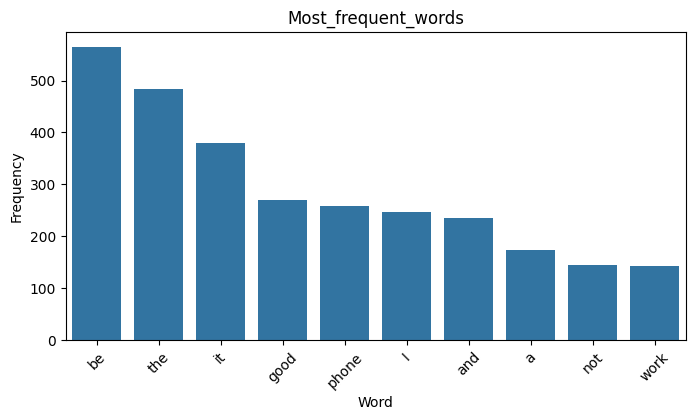

In [13]:
word_freq_plot(most_common_words) # Most frequent words before removing stopwords

In [14]:
#STOP WORDS REMOVAL

def remove_stopwords(text):
    nltk_stopwords=set(stopwords.words("english"))
    stopwords_removed=[word for word in text.split() if word not in nltk_stopwords]
    return stopwords_removed

stopwords_removed=remove_stopwords(text)

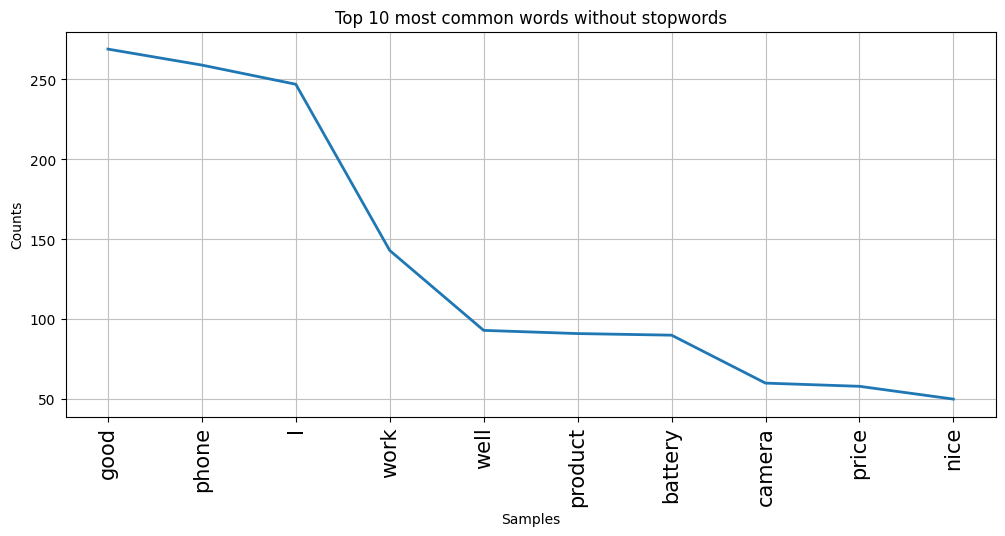

In [15]:
freq_dist=nltk.FreqDist(stopwords_removed)
plt.figure(figsize=(12,5))
plt.title("Top 10 most common words without stopwords")
plt.xticks(fontsize=15)
freq_dist.plot(10,cumulative=False)
plt.show()

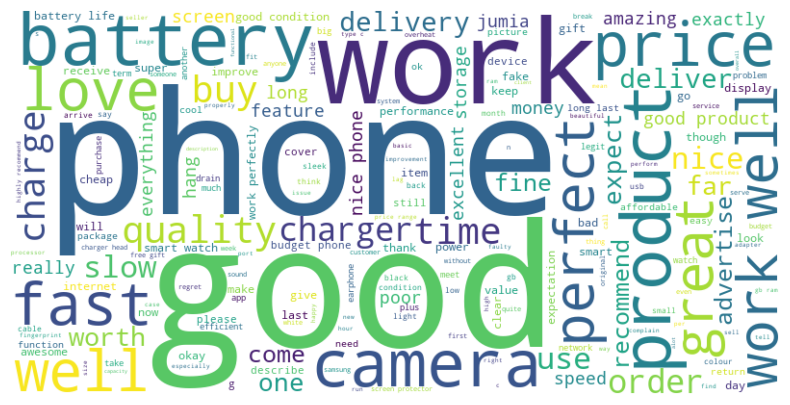

In [111]:
from wordcloud import WordCloud
def word_cloud(filter_tokens):
  text=" ".join(filter_tokens)
  wordcloud=WordCloud(width=800,height=400,background_color="white").generate(text)
  return wordcloud

wc=word_cloud(tokenized)

plt.figure(figsize=(10,5))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
from nltk.util import ngrams
from collections import Counter

bigrams = ngrams(stopwords_removed, 2)
bigram_freq = Counter(bigrams)
print(bigram_freq.most_common(10))

[(('work', 'well'), 54), (('good', 'phone'), 38), (('phone', 'good'), 25), (('good', 'product'), 25), (('I', 'love'), 24), (('I', 'like'), 23), (('phone', 'work'), 21), (('nice', 'phone'), 20), (('I', 'order'), 19), (('good', 'condition'), 18)]


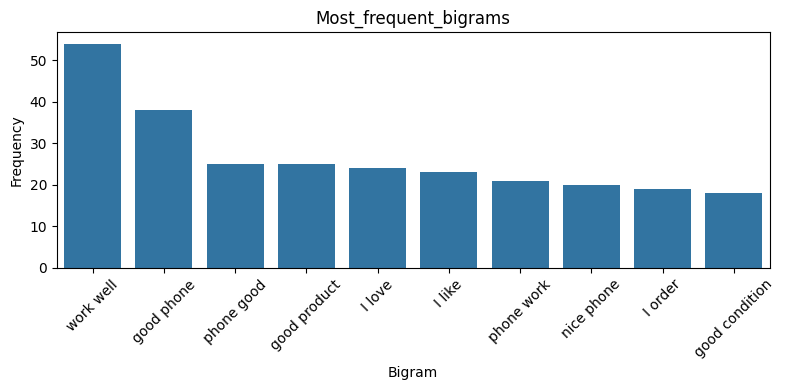

In [18]:
def bigram_freq_plot(bigram_count):
  data2=pd.DataFrame(bigram_count.most_common(10),columns=["Bigram","Frequency"])
  data2["Bigram"]=data2["Bigram"].apply(lambda x: " ".join(x))
  fig=plt.subplots(figsize=(8,4))
  sns.barplot(data=data2,x="Bigram",y="Frequency")
  plt.title("Most_frequent_bigrams")
  plt.xticks(rotation=45)
  plt.tight_layout()
  new_fig=plt.show()
  return new_fig


bigram_freq_plot(bigram_freq)


## NLP 

Rulebased sentiment analysis (Textblob,vader and roberta)

In [19]:
from textblob import TextBlob

blob=TextBlob("I love this product")
print(blob.sentiment)

Sentiment(polarity=0.5, subjectivity=0.6)


In [20]:
def textblob_sentiment_analysis(text):
    if pd.isna(text):
        return None
    blob=TextBlob(text)
    sentiment=blob.sentiment
    if sentiment.polarity > 0:
        return "positive"
    elif sentiment.polarity < 0 :
        return "negative"
    else:
        return "neutral"


In [21]:
merged_df["Textblob_sentiment"]=merged_df["sentiment"].apply(textblob_sentiment_analysis)

In [22]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

def evaluate_sentiment_accuracy(df,true_col,pred_col):
    eval_df =df[[true_col,pred_col]].dropna()
    accuracy=accuracy_score(eval_df[true_col],eval_df[pred_col])
    print(f"Accuracy: {accuracy:.2f}")

    print("\n Classification report:")
    print(classification_report(eval_df[true_col],eval_df[pred_col],zero_division=0))

    print("\n Confusion matrix")
    print(confusion_matrix(eval_df[true_col], eval_df[pred_col]))



In [23]:
evaluate_sentiment_accuracy(merged_df,"sentiment_classification","Textblob_sentiment")

Accuracy: 0.65

 Classification report:
              precision    recall  f1-score   support

    negative       0.58      0.42      0.49       151
     neutral       0.09      0.26      0.13        90
    positive       0.88      0.74      0.81       787

    accuracy                           0.65      1028
   macro avg       0.52      0.47      0.48      1028
weighted avg       0.77      0.65      0.70      1028


 Confusion matrix
[[ 64  54  33]
 [ 21  23  46]
 [ 26 177 584]]


In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia=SentimentIntensityAnalyzer()

In [25]:
sia.polarity_scores("This is a great product!, I am very happy with it.")

{'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.855}

In [26]:
sia.polarity_scores(merged_df["sentiment"].iloc[0])

{'neg': 0.0, 'neu': 0.341, 'pos': 0.659, 'compound': 0.594}

In [27]:
def varder_sentiment_analysis(text):
    if pd.isna(text):
        return None
    scores = sia.polarity_scores(text)
    return scores

sentiment_scores= merged_df["sentiment"].apply(varder_sentiment_analysis).apply(pd.Series)
merged_df = pd.concat([merged_df, sentiment_scores], axis=1)

merged_df.head(5)


,review_about,sentiment,star_rating,date,product_name,price,ratings,discount,brand,number_of_reviews,sentiment_classification,simple_cleaning,lematizated_tech,Textblob_sentiment,neg,neu,pos,compound
0,A70,Good buy ????,5.0,04-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,positive,good buy,"[good, buy]",positive,0.0,0.341,0.659,0.5940
1,Good,"Not bad for the price, good battery , storage ...",4.0,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,positive,not bad for the price good battery storage is...,"[not, bad, for, the, price, good, battery, sto...",positive,0.0,0.635,0.365,0.7935
2,performance,Hangs alot,1.0,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,negative,hangs alot,"[hang, alot]",neutral,0.0,1.000,0.000,0.0000
3,Phone,Good phone,5.0,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,positive,good phone,"[good, phone]",positive,0.0,0.256,0.744,0.4404
4,Bwst,I loved it!!am going to purchase more Thanks J...,5.0,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,positive,i loved itam going to purchase more thanks jumia,"[I, love, itam, go, to, purchase, more, thank,...",positive,0.0,0.439,0.561,0.8261


In [28]:
def sentiment_analysis(text):
    if pd.isna(text):
        return None
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'
    
merged_df["Varder_Sentiment"]=merged_df["sentiment"].apply(sentiment_analysis)

In [29]:
negative_reviews=merged_df[merged_df["Varder_Sentiment"] == "negative"]
negative_reviews.head(5)

,review_about,sentiment,star_rating,date,product_name,price,ratings,discount,brand,number_of_reviews,sentiment_classification,simple_cleaning,lematizated_tech,Textblob_sentiment,neg,neu,pos,compound,Varder_Sentiment
10,Poor performance,Poor battery performance. Won't recommend it a...,1.0,21-05-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,negative,poor battery performance won't recommend it at...,"[poor, battery, performance, will, not, recomm...",negative,0.465,0.535,0.0,-0.6381,negative
13,Excellent I like it,Arrived on time and no regrets,4.0,14-05-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,positive,arrived on time and no regrets,"[arrive, on, time, and, no, regret]",positive,0.540,0.460,0.0,-0.5719,negative
68,Poor battery,Battery drains faster than that of normal phon...,2.0,17-03-2025,"Itel A60s, 6.6"", 128GB + 4GB RAM, Dual SIM, 50...",9360.0,4.1,19%,Itel,85.0,negative,battery drains faster than that of normal phon...,"[battery, drain, fast, than, that, of, normal,...",negative,0.237,0.763,0.0,-0.4767,negative
77,poor,Switching off Poor battery,1.0,20-01-2025,"Itel A60s, 6.6"", 128GB + 4GB RAM, Dual SIM, 50...",9360.0,4.1,19%,Itel,85.0,negative,switching off poor battery,"[switch, off, poor, battery]",negative,0.508,0.492,0.0,-0.4767,negative
88,"It's working well, I thought it has fingerprints.",It was packed so bad if the driver was not car...,3.0,09-06-2025,"Samsung Galaxy A05, 6.7'' 4GB RAM + 64GB ROM (...",9349.0,4.1,38%,Samsung,437.0,neutral,it was packed so bad if the driver was not car...,"[it, be, pack, so, bad, if, the, driver, be, n...",negative,0.298,0.702,0.0,-0.7127,negative


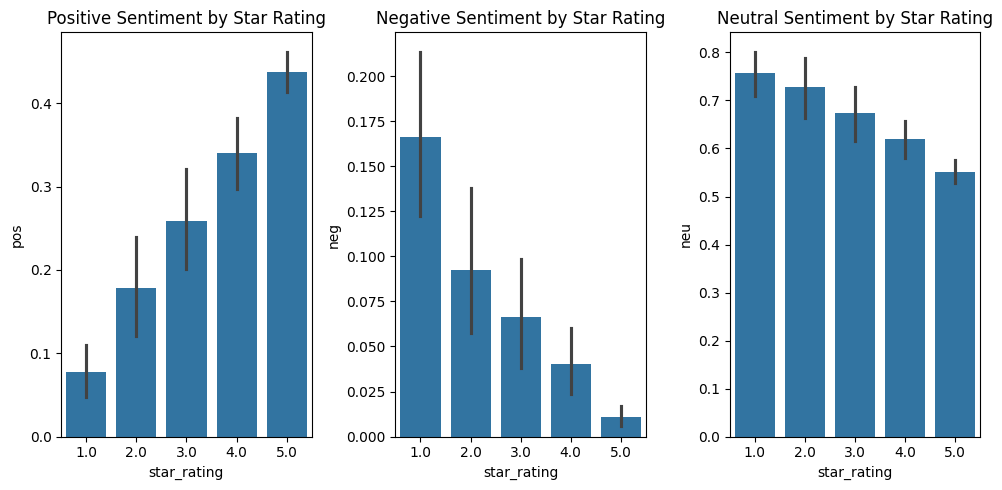

In [30]:
fig,axs=plt.subplots(1,3,figsize=(10,5))
sns.barplot(ax=axs[0],data=merged_df,x="star_rating",y="pos")
sns.barplot(ax=axs[1],data=merged_df,x="star_rating",y="neg")
sns.barplot(ax=axs[2],data=merged_df,x="star_rating",y="neu")
axs[0].set_title("Positive Sentiment by Star Rating")
axs[1].set_title("Negative Sentiment by Star Rating")
axs[2].set_title("Neutral Sentiment by Star Rating")
plt.tight_layout()
plt.show()

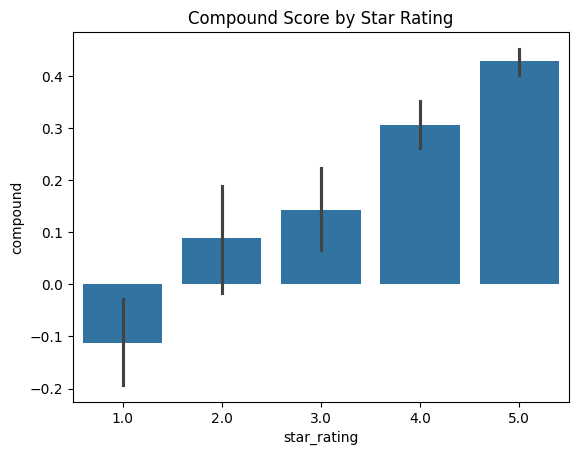

In [31]:
ax=sns.barplot(data=merged_df,x="star_rating",y="compound")
ax.set_title("Compound Score by Star Rating")
plt.show()

In [32]:
# accuracy_testing\
evaluate_sentiment_accuracy(merged_df,"sentiment_classification","Varder_Sentiment")

Accuracy: 0.66

 Classification report:
              precision    recall  f1-score   support

    negative       0.57      0.37      0.45       151
     neutral       0.12      0.32      0.17        90
    positive       0.87      0.75      0.81       787

    accuracy                           0.66      1028
   macro avg       0.52      0.48      0.48      1028
weighted avg       0.76      0.66      0.70      1028


 Confusion matrix
[[ 56  50  45]
 [ 16  29  45]
 [ 26 167 594]]


Roberta

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "cardiffnlp/twitter-roberta-base-sentiment"  # working version
tokenizer = AutoTokenizer.from_pretrained(model_name,cache_dir="./models")
model = AutoModelForSequenceClassification.from_pretrained(model_name,cache_dir="./models")



In [35]:
example="This is a product!."
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [36]:
extend_text=tokenizer(example, return_tensors="pt")
output = model(**extend_text)
scores=output[0][0].detach().numpy()
scores=softmax(scores)
score_dict={
    "roberta_negative":float(scores[0]),
    "roberta_neutral":float(scores[1]),
    "roberta_positive":float(scores[2])
}
score_dict

{'roberta_negative': 0.21400687098503113,
 'roberta_neutral': 0.630069375038147,
 'roberta_positive': 0.1559237241744995}

In [37]:
def polarity_scores_analysis(text):
    if pd.isna(text):
        return {"roberta_negative":None,"roberta_neutral":None,"roberta_positive":None}
    encoded_text=tokenizer(text,return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    score_dict ={
        "roberta_negative":float(scores[0]),
        "roberta_neutral":float(scores[1]),
        "roberta_positive":float(scores[2])
    }
    return score_dict

In [38]:
df_scores=merged_df["sentiment"].apply(polarity_scores_analysis).apply(pd.Series)
merged_df=pd.concat([merged_df,df_scores],axis=1)

In [39]:
sentiment_cols = ["roberta_negative", "roberta_neutral", "roberta_positive"]

# Replace fully-NaN rows with a default (optional, can also leave as NaN)
merged_df["roberta_sentiment"] = (
    merged_df[sentiment_cols]
    .fillna(-1)  # Fill NaNs so idxmax doesn't error out
    .idxmax(axis=1)
    .where(merged_df[sentiment_cols].notna().any(axis=1))  # Restore NaN if all were NaN
    .str.replace("roberta_", "")
)

In [40]:
# accuracy_testing
merged_df.columns.tolist()
evaluate_sentiment_accuracy(merged_df,"sentiment_classification","roberta_sentiment")

Accuracy: 0.69

 Classification report:
              precision    recall  f1-score   support

    negative       0.63      0.62      0.62       151
     neutral       0.12      0.33      0.18        90
    positive       0.93      0.75      0.83       787

    accuracy                           0.69      1028
   macro avg       0.56      0.57      0.54      1028
weighted avg       0.81      0.69      0.74      1028


 Confusion matrix
[[ 93  42  16]
 [ 31  30  29]
 [ 23 176 588]]


#### NLP Analysis

In [41]:
filtered_df= merged_df[(merged_df["Textblob_sentiment"]==merged_df["Varder_Sentiment"])&
              (merged_df["Varder_Sentiment"]==merged_df["roberta_sentiment"])&
              (merged_df["sentiment_classification"] != merged_df["roberta_sentiment"])]

In [42]:
filtered_df[-20:]

,review_about,sentiment,star_rating,date,product_name,price,ratings,discount,brand,number_of_reviews,sentiment_classification,simple_cleaning,lematizated_tech,Textblob_sentiment,neg,neu,pos,compound,Varder_Sentiment,roberta_negative,roberta_neutral,roberta_positive,roberta_sentiment
966,I like it,As advertised,5.0,28-05-2025,"XIAOMI REDMI A3X ,6.71 INCHES DISPLAY,5000MAH,...",8200.0,4.3,32%,XIAOMI,6.0,positive,as advertised,"[as, advertise]",neutral,0.000,1.000,0.000,0.0000,neutral,0.242561,0.709916,0.047523,neutral
984,good,Check on cyargers,4.0,05-12-2024,"Freeyond F9,2GB+64GB,6.52"", 13.0MP,4G Smartpho...",7199.0,4.0,45%,Freeyond,495.0,positive,check on cyargers,"[check, on, cyarger]",neutral,0.000,1.000,0.000,0.0000,neutral,0.124863,0.810374,0.064763,neutral
988,I don't like it,It hangs alot,1.0,13-08-2024,"Freeyond F9,2GB+64GB,6.52"", 13.0MP,4G Smartpho...",7199.0,4.0,45%,Freeyond,495.0,negative,it hangs alot,"[it, hang, alot]",neutral,0.000,1.000,0.000,0.0000,neutral,0.289668,0.648038,0.062294,neutral
990,not bad,It hangs alot but the battery is ok,2.0,28-06-2024,"Freeyond F9,2GB+64GB,6.52"", 13.0MP,4G Smartpho...",7199.0,4.0,45%,Freeyond,495.0,negative,it hangs alot but the battery is ok,"[it, hang, alot, but, the, battery, be, ok]",positive,0.000,0.714,0.286,0.4215,positive,0.012061,0.198101,0.789838,positive
996,good,I received on time and working good ????,2.0,08-08-2024,"Infinix Smart 8, 6.6"" HD Display, 2GB RAM Expa...",8699.0,4.0,57%,Infinix,46.0,negative,i received on time and working good,"[I, receive, on, time, and, work, good]",positive,0.000,0.609,0.391,0.5940,positive,0.014899,0.168656,0.816445,positive
1001,worthy,Just as advertised,4.0,21-06-2024,"Infinix Smart 8, 6.6"" HD Display, 2GB RAM Expa...",8699.0,4.0,57%,Infinix,46.0,positive,just as advertised,"[just, as, advertise]",neutral,0.000,1.000,0.000,0.0000,neutral,0.323947,0.603566,0.072487,neutral
1009,Yes,"This is my 3rd Itel smart phone, the thing I h...",3.0,18-03-2024,Itel A70 6.6 DISPLAY UPTO 8GB RAM + 128GB ROM ...,9450.0,4.4,37%,Itel,31.0,neutral,this is my 3rd itel smart phone the thing i ha...,"[this, be, my, 3rd, itel, smart, phone, the, t...",negative,0.165,0.731,0.104,-0.3786,negative,0.977591,0.018820,0.003589,negative
1012,product quality,Services,5.0,29-04-2025,"Itel A70,UPTO 8GB RAM +128GB STORAGE,5000MAH+W...",9995.0,3.5,41%,Itel,13.0,positive,services,[service],neutral,0.000,1.000,0.000,0.0000,neutral,0.255265,0.542559,0.202176,neutral
1023,i like,Storage is poor small,3.0,24-03-2025,Samsung Galaxy A05 64GB+4GB 50MP Triple Camera...,9999.0,3.7,50%,Samsung,10.0,neutral,storage is poor small,"[storage, be, poor, small]",negative,0.508,0.492,0.000,-0.4767,negative,0.813535,0.172061,0.014404,negative
1027,The product is user friendly,Its best,3.0,25-03-2025,"Freeyond F9,3GB+128GB,6.52"" 4G Smartphone,13.0...",8699.0,3.9,49%,Freeyond,349.0,neutral,its best,"[its, good]",positive,0.000,0.192,0.808,0.6369,positive,0.034567,0.295044,0.670389,positive


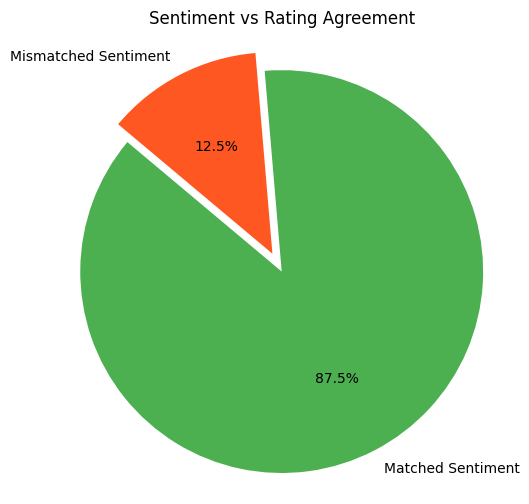

In [43]:
labels = ['Matched Sentiment', 'Mismatched Sentiment']
sizes = [len(merged_df), len(filtered_df)]
colors = ['#4CAF50', '#FF5722']
explode = (0, 0.1)

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment vs Rating Agreement')
plt.axis('equal')
plt.show()

In [44]:
merged_df.columns.tolist()

['review_about',
 'sentiment',
 'star_rating',
 'date',
 'product_name',
 'price',
 'ratings',
 'discount',
 'brand',
 'number_of_reviews',
 'sentiment_classification',
 'simple_cleaning',
 'lematizated_tech',
 'Textblob_sentiment',
 'neg',
 'neu',
 'pos',
 'compound',
 'Varder_Sentiment',
 'roberta_negative',
 'roberta_neutral',
 'roberta_positive',
 'roberta_sentiment']

In [45]:
def checking_aggrement(row):
    sentiment=[row["Textblob_sentiment"],row["Varder_Sentiment"],row["roberta_sentiment"]]
    return len(set(sentiment)) ==1

In [46]:
new_df=merged_df.copy()
new_df["aggrement"]= merged_df.apply(checking_aggrement, axis=1)
aggrement_rate=new_df["aggrement"].mean()*100
print(f"All three agree on {aggrement_rate:.2f}% of the data")

All three agree on 65.60% of the data


In [47]:
# Polarization of products 
brand_counts=merged_df["brand"].value_counts()
valid_brands=brand_counts[brand_counts >= 5 ] . index
filtered_df2= merged_df[merged_df["brand"].isin(valid_brands)]


brand_std=filtered_df2.groupby("brand")["star_rating"].std().sort_values(ascending=False)

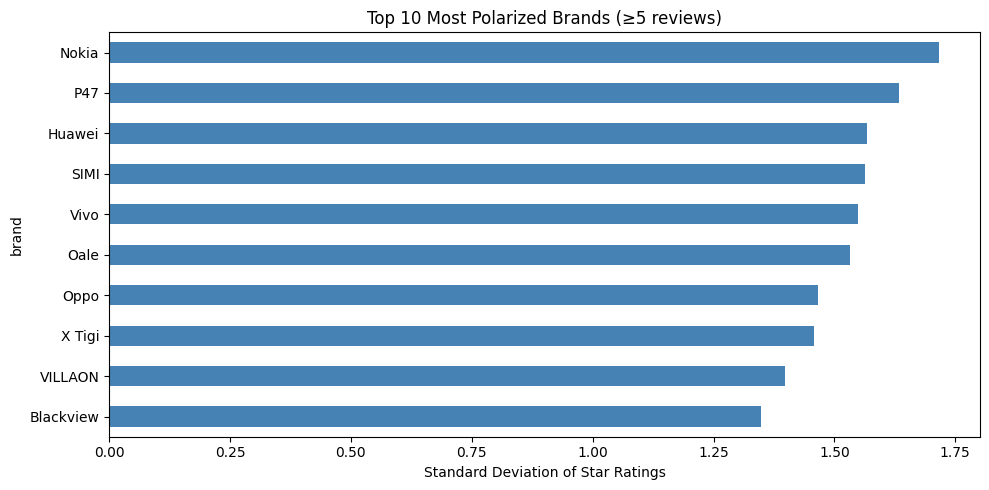

In [48]:
top_polarized= brand_std.head(10)
plt.figure(figsize=(10, 5))
top_polarized.plot(kind="barh", color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top 10 Most Polarized Brands (≥5 reviews)")
plt.xlabel("Standard Deviation of Star Ratings")
plt.tight_layout()
plt.show()

Topic modelling

In [49]:
from gensim import corpora, models 
from gensim.parsing.preprocessing import remove_stopwords
import pyLDAvis
import pickle
import os


In [50]:
texts=merged_df['lematizated_tech'].tolist()
text_cleaned=[[word for word in doc if word not in nltk.corpus.stopwords.words("english")] for doc in texts]
dictionary =corpora.Dictionary(text_cleaned)
corpus=[dictionary.doc2bow(text) for text in text_cleaned]

lda_model = models.LdaModel(corpus=corpus,id2word = dictionary, num_topics=3,passes=10)

In [51]:
for idx,topic in lda_model.print_topics():
    print(f"Topic {idx}: {topic}")

Topic 0: 0.076*"good" + 0.045*"I" + 0.033*"battery" + 0.029*"product" + 0.018*"camera" + 0.018*"like" + 0.018*"perfect" + 0.017*"love" + 0.014*"charger" + 0.014*"fast"
Topic 1: 0.079*"phone" + 0.047*"work" + 0.035*"good" + 0.034*"I" + 0.034*"well" + 0.017*"nice" + 0.015*"great" + 0.010*"slow" + 0.008*"time" + 0.007*"money"
Topic 2: 0.043*"I" + 0.026*"order" + 0.022*"phone" + 0.015*"price" + 0.015*"buy" + 0.014*"recommend" + 0.011*"use" + 0.011*"item" + 0.010*"product" + 0.010*"gb"


In [52]:
import pyLDAvis.gensim_models as gensimvis


LDAvis_prepared=gensimvis.prepare(lda_model,corpus,dictionary)

pyLDAvis.save_html(LDAvis_prepared,"lda_visualization.html")

pyLDAvis.enable_notebook()
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.058551  0.107650       1        1  44.083352
0     -0.076885 -0.098355       2        1  36.976900
2      0.135436 -0.009296       3        1  18.939748, topic_info=        Term        Freq       Total Category  logprob  loglift
1       good  222.000000  222.000000  Default  30.0000  30.0000
12     phone  214.000000  214.000000  Default  29.0000  29.0000
33      well   77.000000   77.000000  Default  28.0000  28.0000
34      work  118.000000  118.000000  Default  27.0000  27.0000
129    order   28.000000   28.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
9    storage    4.378468   17.220947   Topic3  -5.3972   0.2945
222  quality    4.901719   32.009032   Topic3  -5.2843  -0.2125
42      come    4.404097   19.697829   Topic3  -5.3913   0.1659
88   receive    4.135597   13.124788   Topic3  -5.4542   0.5090
52       one    4.329157   21.374316   Topic3  -5.4085   0.0671

[203 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
585       1  0.867006      2
585       3  0.173401      2
207       2  0.912951      8
13        1  0.378234      I
13        2  0.417531      I
...     ...       ...    ...
143       2  0.393929  worth
143       3  0.315143  worth
121       1  0.260447  would
121       2  0.694524  would
178       2  0.912973    wow

[274 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [53]:
def assign_lda_topics_from_lemmatized(df,lemmatized_col,lda_model,dictionary,topic_labels_dict=None):
    dominant_topics = []
    topic_probs = []
    topic_labels = []

    for tokens in df[lemmatized_col]:
        if not isinstance(tokens, list) or len(tokens) == 0:
            dominant_topics.append(None)
            topic_probs.append(0.0)
            topic_labels.append(None if topic_labels_dict else "")
            continue

        bow = dictionary.doc2bow(tokens)
        topics = lda_model.get_document_topics(bow)

        if topics:
            top_topic = max(topics, key=lambda x: x[1])
            dominant_topics.append(top_topic[0])
            topic_probs.append(round(top_topic[1], 4))
            topic_labels.append(topic_labels_dict.get(top_topic[0], f"Topic {top_topic[0]}") if topic_labels_dict else "")
        else:
            dominant_topics.append(None)
            topic_probs.append(0.0)
            topic_labels.append(None if topic_labels_dict else "")

    df = df.copy()
    df["Dominant_Topic"] = dominant_topics
    df["Topic_Probability"] = topic_probs
    if topic_labels_dict:
        df["Topic_Label"] = topic_labels

    return df

In [54]:
topic_labels={
    0: "Customer_satisfaction",
    1: "Phone and it's features",
    2: "Jumia services"
}
df=assign_lda_topics_from_lemmatized(merged_df,'lematizated_tech',lda_model,dictionary,topic_labels)

In [55]:
df

,review_about,sentiment,star_rating,date,product_name,price,ratings,discount,brand,number_of_reviews,sentiment_classification,simple_cleaning,lematizated_tech,Textblob_sentiment,neg,neu,pos,compound,Varder_Sentiment,roberta_negative,roberta_neutral,roberta_positive,roberta_sentiment,Dominant_Topic,Topic_Probability,Topic_Label
0,A70,Good buy ????,5.0,04-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,positive,good buy,"[good, buy]",positive,0.0,0.341,0.659,0.5940,positive,0.037337,0.613820,0.348843,neutral,0.0,0.5041,Customer_satisfaction
1,Good,"Not bad for the price, good battery , storage ...",4.0,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,positive,not bad for the price good battery storage is...,"[not, bad, for, the, price, good, battery, sto...",positive,0.0,0.635,0.365,0.7935,positive,0.013257,0.075598,0.911145,positive,0.0,0.9307,Customer_satisfaction
2,performance,Hangs alot,1.0,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,negative,hangs alot,"[hang, alot]",neutral,0.0,1.000,0.000,0.0000,neutral,0.085382,0.799665,0.114952,neutral,0.0,0.6275,Customer_satisfaction
3,Phone,Good phone,5.0,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,positive,good phone,"[good, phone]",positive,0.0,0.256,0.744,0.4404,positive,0.005041,0.061103,0.933856,positive,1.0,0.7218,Phone and it's features
4,Bwst,I loved it!!am going to purchase more Thanks J...,5.0,03-06-2025,"Itel A70, 6.6"", 3GB RAM + 128GB, 4G, (Dual SIM...",8370.0,4.1,26%,Itel,162.0,positive,i loved itam going to purchase more thanks jumia,"[I, love, itam, go, to, purchase, more, thank,...",positive,0.0,0.439,0.561,0.8261,positive,0.001454,0.008160,0.990387,positive,1.0,0.6720,Phone and it's features
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,owesome,It's a good phone. Works very well.,5.0,10-03-2025,"Realme Note 50, 6.7"", 64GB + 3GB RAM (Dual SIM...",9849.0,4.2,18%,Realme,20.0,positive,it's a good phone works very well,"[it, be, a, good, phone, work, very, well]",positive,0.0,0.430,0.570,0.6478,positive,0.002022,0.014060,0.983918,positive,1.0,0.8580,Phone and it's features
1087,realme note50,"The phone is everything, cheap with the right ...",5.0,10-03-2025,"Realme Note 50, 6.7"", 64GB + 3GB RAM (Dual SIM...",9849.0,4.2,18%,Realme,20.0,positive,the phone is everything cheap with the right f...,"[the, phone, be, everything, cheap, with, the,...",positive,0.0,1.000,0.000,0.0000,neutral,0.002974,0.035197,0.961829,positive,1.0,0.7284,Phone and it's features
1088,best,Good performance,5.0,14-02-2025,"Realme Note 50, 6.7"", 64GB + 3GB RAM (Dual SIM...",9849.0,4.2,18%,Realme,20.0,positive,good performance,"[good, performance]",positive,0.0,0.256,0.744,0.4404,positive,0.005931,0.076871,0.917197,positive,1.0,0.6581,Phone and it's features
1089,I like it,"It was as advertised, very reliable",4.0,13-01-2025,"Realme Note 50, 6.7"", 64GB + 3GB RAM (Dual SIM...",9849.0,4.2,18%,Realme,20.0,positive,it was as advertised very reliable,"[it, be, as, advertise, very, reliable]",positive,0.0,1.000,0.000,0.0000,neutral,0.004604,0.095058,0.900338,positive,2.0,0.4787,Jumia services


In [56]:
# Count how many positive/negative/neutral reviews each topic has
sentiment_summary = df.groupby(["Topic_Label", "sentiment_classification"]).size().unstack(fill_value=0)
print(sentiment_summary)

sentiment_classification  negative  neutral  positive
Topic_Label                                          
Customer_satisfaction           50       32       347
Jumia services                  36       22       106
Phone and it's features         64       36       334


jumia services tend to have the most polar of the sentiments

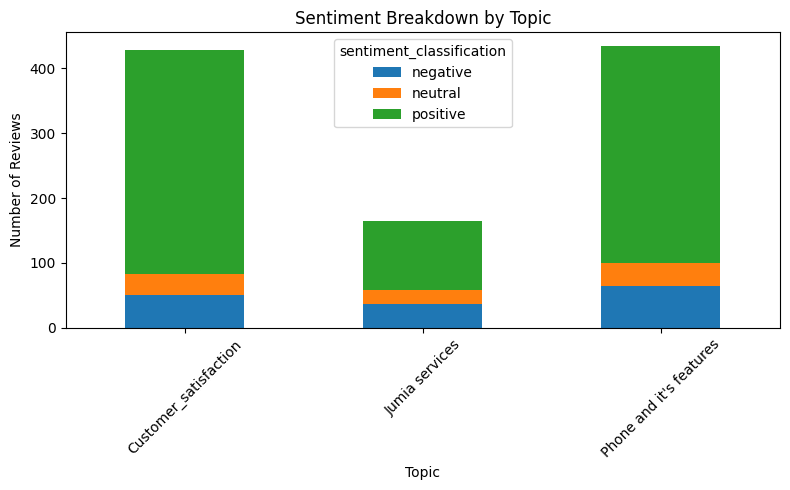

In [57]:
sentiment_summary.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Sentiment Breakdown by Topic")
plt.ylabel("Number of Reviews")
plt.xlabel("Topic")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Machine Learning

Logistic Regression and preprocessing

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack


In [59]:
df["simple_cleaning"]=df["simple_cleaning"].fillna("")
df["Topic_Label"]=df["Topic_Label"].fillna("")

In [60]:
for max_f in [100,200,300,500,1000]:
    vectorizer= TfidfVectorizer(max_features=max_f, ngram_range=(1,2))
    X =  vectorizer.fit_transform(df["simple_cleaning"])
    scores=cross_val_score(LogisticRegression(),X,df["sentiment_classification"],cv=5)
    print(f"Max features={max_f}, Accuracy= {scores.mean():.4f}")

Max features=100, Accuracy= 0.7897
Max features=200, Accuracy= 0.8052
Max features=300, Accuracy= 0.8033
Max features=500, Accuracy= 0.7917
Max features=1000, Accuracy= 0.7839


In [61]:
for max_f in [100,200,300,500,1000]:
    vectorizer= TfidfVectorizer(max_features=max_f, ngram_range=(1,2))
    X1 =  vectorizer.fit_transform(df["simple_cleaning"])
    vectorizer= TfidfVectorizer(max_features=5)
    X2 = vectorizer.fit_transform(df["Topic_Label"]) 
    X_combined = hstack([X1,X2])
    scores=cross_val_score(LogisticRegression(),X,df["sentiment_classification"],cv=5)
    print(f"Max features={max_f}, Accuracy= {scores.mean():.4f}")

Max features=100, Accuracy= 0.7839
Max features=200, Accuracy= 0.7839
Max features=300, Accuracy= 0.7839
Max features=500, Accuracy= 0.7839
Max features=1000, Accuracy= 0.7839


In [86]:

vectorizer= TfidfVectorizer(max_features=5)
X2 = vectorizer.fit_transform(df["Topic_Label"]) 
vectorizer= TfidfVectorizer(max_features=200, ngram_range=(1,2))
X1 =  vectorizer.fit_transform(df["simple_cleaning"])
y= df["sentiment_classification"]
X=hstack([X1,X2])

so one feature and only the topics part is destroying the accuracy 

#### NAIVE BAYES

In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [92]:
X_train, X_test,y_train,y_test=train_test_split(X1,y, test_size=0.2,random_state=42)
model1= MultinomialNB()
model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.73      0.38      0.50        29
     neutral       0.00      0.00      0.00        16
    positive       0.83      0.98      0.90       162

    accuracy                           0.82       207
   macro avg       0.52      0.45      0.47       207
weighted avg       0.75      0.82      0.78       207



SVM

In [93]:
from sklearn.svm import SVC
model2=SVC(kernel="linear", class_weight="balanced",probability=True)
model2.fit(X_train,y_train)
y_pred=model2.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.40      0.59      0.48        29
     neutral       0.14      0.31      0.20        16
    positive       0.91      0.73      0.81       162

    accuracy                           0.68       207
   macro avg       0.49      0.54      0.49       207
weighted avg       0.78      0.68      0.71       207



lets add some weight and try to try and catch the negative reviews

In [94]:
from imblearn.over_sampling import SMOTE

smote =SMOTE(random_state=42)
X_resampled,y_resampled=smote.fit_resample(X1,y)

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
model3=SVC(kernel="linear", class_weight="balanced",probability=True)
model3.fit(X_train,y_train)
y_pred=model3.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

    negative       0.71      0.86      0.78       172
     neutral       0.77      0.66      0.71       145
    positive       0.76      0.70      0.73       156

    accuracy                           0.74       473
   macro avg       0.75      0.74      0.74       473
weighted avg       0.75      0.74      0.74       473



Prediction of a review

In [101]:
def predict_sentiment(review,model=model2,vectorizer=vectorizer):
    cleaned_review=cleaning_text(review)
    review_vector=vectorizer.transform([cleaned_review])
    predict_label=model.predict(review_vector)[0]
    probas=model.predict_proba(review_vector)[0]
    probas_dict = dict(zip(model.classes_, probas.round(3)))

    return {
        "cleaned_text": cleaned_review,
        "predicted_sentiment": predict_label,
        "class_probabilities": probas_dict
    }

In [106]:
result = predict_sentiment(
    "Poor batery  "
)

print("Predicted Sentiment:", result["predicted_sentiment"])
print("Class Probabilities:", result["class_probabilities"])

Predicted Sentiment: negative
Class Probabilities: {'negative': 0.608, 'neutral': 0.148, 'positive': 0.245}
